Now import TensorFlow and the module dependencies:

In [ ]:
!pip install tensorflow==2.4.1
!pip install gpustat
import numpy as np
import tensorflow as tf
from keras.utils.np_utils import to_categorical
import time

     |████████████████████████████████| 81kB 4.5MB/s 
  Created wheel for gpustat: filename=gpustat-0.6.0-cp37-none-any.whl size=12621 sha256=004ebf6f92f008156373326e07ae5f39c61c83b9f9a4be7bc9ad25f820a3aefb
  Stored in directory: /root/.cache/pip/wheels/48/b4/d5/fb5b7f1d040f2ff20687e3bad6867d63155dbde5a7c10f4293
Successfully built gpustat


In [ ]:
# data normalization

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

x_train = x_train - np.mean(x_train)
x_test = x_test - np.mean(x_test)


# reshape
x_train = np.reshape(x_train, (60000, 784))
x_test = np.reshape(x_test, (10000, 784))

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:

class MLP_0():

  # initialization
  def __init__(self, sizes, epochs=100, l_rate=0.001):
      self.sizes = sizes
      self.epochs = epochs
      self.l_rate = l_rate
      self.params = self.initialization()

  def softmax(self, x, derivative=False):
          exps = np.exp(x - x.max())
          if derivative:
              return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
          return exps / np.sum(exps, axis=0)

  def sigmoid(self, x, derivative=False):
          if derivative:
              return (np.exp(-x))/((np.exp(-x)+1)**2)
          return 1/(1 + np.exp(-x))


  # with no hidden layer
  def initialization(self):
          # nums of computing units in each layer
          input_layer=self.sizes[0]
          output_layer=self.sizes[1]
          params = {
              'W0':np.random.randn(output_layer, input_layer) * np.sqrt(1. / output_layer)
          }
          return params

  def forward(self, x_train):
          params = self.params
          params['A0'] = x_train
          # direct from input layer to output layer
          params['A1']=np.dot(params['W0'], params['A0'])
          #softmax at the end of classification
          # note, after I change sigmoid to softmax, the accuracy drops
          params['S1'] =self.softmax(params['A1'])
          return params['S1']


  def backward(self, y_train, output):
          params = self.params
          changes_to_w = {}
          # Calculate W1 update
          error = 2 * (output - y_train) / output.shape[0]  *self.softmax(params['A1'], derivative=True)
          changes_to_w['W0'] = np.outer(error, params['A0'])
          return changes_to_w


  def update_network_parameters(self, changes_to_w):        
          for key, value in changes_to_w.items():
              self.params[key] -= self.l_rate * value

  def train(self, x_train, y_train, x_val, y_val):
          start_time = time.time()
          for iteration in range(self.epochs):
              for x,y in zip(x_train, y_train):
                  output = self.forward(x)
                  changes_to_w = self.backward(y, output)
                  self.update_network_parameters(changes_to_w)
              
              accuracy = self.evaluate_acc(x_val, y_val)
              print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                  iteration+1, time.time() - start_time, accuracy * 100
              ))
  def evaluate_acc(self, x_val, y_val):
          predictions = []

          for x, y in zip(x_val, y_val):
              output = self.forward(x)
              pred = np.argmax(output)
              predictions.append(pred == np.argmax(y))
          
          return np.mean(predictions)


  


In [ ]:
mlp0 = MLP_0(sizes=[784,10])
mlp0.train(x_train,y_train,x_train,y_train)

Epoch: 1, Time Spent: 6.53s, Accuracy: 12.08%
Epoch: 2, Time Spent: 13.00s, Accuracy: 26.24%
Epoch: 3, Time Spent: 19.45s, Accuracy: 39.92%
Epoch: 4, Time Spent: 25.95s, Accuracy: 50.52%
Epoch: 5, Time Spent: 32.41s, Accuracy: 57.69%
Epoch: 6, Time Spent: 38.93s, Accuracy: 63.66%
Epoch: 7, Time Spent: 45.39s, Accuracy: 67.98%
Epoch: 8, Time Spent: 51.90s, Accuracy: 71.22%
Epoch: 9, Time Spent: 58.37s, Accuracy: 73.46%
Epoch: 10, Time Spent: 64.88s, Accuracy: 75.38%
Epoch: 11, Time Spent: 71.45s, Accuracy: 76.88%
Epoch: 12, Time Spent: 77.94s, Accuracy: 78.05%
Epoch: 13, Time Spent: 84.40s, Accuracy: 79.02%
Epoch: 14, Time Spent: 90.90s, Accuracy: 79.88%
Epoch: 15, Time Spent: 97.40s, Accuracy: 80.58%
Epoch: 16, Time Spent: 104.02s, Accuracy: 81.20%
Epoch: 17, Time Spent: 110.52s, Accuracy: 81.71%
Epoch: 18, Time Spent: 117.00s, Accuracy: 82.18%
Epoch: 19, Time Spent: 123.49s, Accuracy: 82.61%
Epoch: 20, Time Spent: 130.00s, Accuracy: 83.00%
Epoch: 21, Time Spent: 136.56s, Accuracy: 83.

In [ ]:
class MLP_1():

    def __init__(self, sizes, epochs=500, l_rate=0.0001):
          self.sizes = sizes
          self.epochs = epochs
          self.l_rate = l_rate
          # we save all parameters in the neural network in this dictionary
          self.params = self.initialization()

    def softmax(self, x, derivative=False):
        # Numerically stable with large exponentials
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def initialization(self):
        # number of nodes in each layer
        input_layer = self.sizes[0]
        hidden_1 = self.sizes[1]
        output_layer = self.sizes[2]

        params = {
            'W1': np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2': np.random.randn(output_layer, hidden_1) * np.sqrt(1. / output_layer)
        }

        return params

    def forward_pass(self, x_train):
        params = self.params

        # input layer activations becomes sample
        params['A0'] = x_train

        # input layer to hidden layer 1
        params['Z1'] = np.dot(params["W1"], params['A0'])
        params['A1'] = self.ReLU(params['Z1'])
        # hidden layer 1 to hidden layer 2
        params['Z2'] = np.dot(params["W2"], params['A1'])
        params['A2'] = self.softmax(params['Z2'])


        return params['A2']

    def backward_pass(self, y_train, output):
        '''
            This is the backpropagation algorithm, for calculating the updates
            of the neural network's parameters.

            Note: There is a stability issue that causes warnings. This is
                  caused  by the dot and multiply operations on the huge arrays.

                  RuntimeWarning: invalid value encountered in true_divide
                  RuntimeWarning: overflow encountered in exp
                  RuntimeWarning: overflow encountered in square
        '''
        params = self.params
        change_w = {}

        # Calculate W2 update
        error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z2'], derivative=True)
        change_w['W2'] = np.outer(error, params['A1'])
        # Calculate W1 update
        error = np.dot(params['W2'].T, error) * self.ReLU(params['Z1'], derivative=True)
        change_w['W1'] = np.outer(error, params['A0'])

        return change_w

    def update_network_parameters(self, changes_to_w):
        '''
            Update network parameters according to update rule from
            Stochastic Gradient Descent.

            θ = θ - η * ∇J(x, y),
                theta θ:            a network parameter (e.g. a weight w)
                eta η:              the learning rate
                gradient ∇J(x, y):  the gradient of the objective function,
                                    i.e. the change for a specific theta θ
        '''

        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_val, y_val):
        '''
            This function does a forward pass of x, then checks if the indices
            of the maximum value in the output equals the indices in the label
            y. Then it sums over each prediction and calculates the accuracy.
        '''
        predictions = []

        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))

        return np.mean(predictions)

    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        for iteration in range(self.epochs):
            for x, y in zip(x_train, y_train):
                output = self.forward_pass(x)
                changes_to_w = self.backward_pass(y, output)
                self.update_network_parameters(changes_to_w)

            accuracy = self.compute_accuracy(x_val, y_val)
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration + 1, time.time() - start_time, accuracy * 100
            ))
    def ReLU(self, x, derivative = False):
            if derivative:
              y = x
              y[y <= 0] = 0
              y[y > 0] = 1
              return y
            x[x <= 0] = 0
            return x

  

In [ ]:
mlp1 = MLP_1(sizes=[784,128,10])
mlp1.train(x_train,y_train,x_train,y_train)

Epoch: 1, Time Spent: 45.63s, Accuracy: 21.39%
Epoch: 2, Time Spent: 90.91s, Accuracy: 34.76%
Epoch: 3, Time Spent: 136.21s, Accuracy: 42.83%
Epoch: 4, Time Spent: 181.45s, Accuracy: 50.78%
Epoch: 5, Time Spent: 226.66s, Accuracy: 58.15%
Epoch: 6, Time Spent: 271.74s, Accuracy: 63.56%
Epoch: 7, Time Spent: 317.07s, Accuracy: 67.53%
Epoch: 8, Time Spent: 362.47s, Accuracy: 70.59%
Epoch: 9, Time Spent: 409.08s, Accuracy: 72.94%
Epoch: 10, Time Spent: 455.68s, Accuracy: 74.87%
Epoch: 11, Time Spent: 502.09s, Accuracy: 76.44%
Epoch: 12, Time Spent: 548.86s, Accuracy: 77.69%
Epoch: 13, Time Spent: 595.37s, Accuracy: 78.78%
Epoch: 14, Time Spent: 641.80s, Accuracy: 79.74%
Epoch: 15, Time Spent: 688.48s, Accuracy: 80.50%
Epoch: 16, Time Spent: 734.95s, Accuracy: 81.25%
Epoch: 17, Time Spent: 781.45s, Accuracy: 81.87%
Epoch: 18, Time Spent: 827.85s, Accuracy: 82.49%
Epoch: 19, Time Spent: 874.11s, Accuracy: 82.93%
Epoch: 20, Time Spent: 920.80s, Accuracy: 83.40%
Epoch: 21, Time Spent: 967.08s,

KeyboardInterrupt: ignored

[0.214, 0.348, 0.428, 0.508, 0.582, 0.636, 0.675, 0.706, 0.729, 0.749, 0.764, 0.777, 0.788, 0.797, 0.805, 0.812, 0.819, 0.825, 0.829, 0.834, 0.838, 0.842, 0.846, 0.85, 0.853, 0.855, 0.858, 0.86, 0.862, 0.864, 0.866, 0.868, 0.869, 0.871, 0.872, 0.874, 0.875, 0.877, 0.878, 0.879, 0.88, 0.882, 0.882, 0.883, 0.884, 0.885, 0.886, 0.887, 0.888, 0.889, 0.889, 0.89, 0.891, 0.891, 0.892, 0.893, 0.893, 0.894, 0.895, 0.896, 0.896, 0.897, 0.898, 0.898, 0.899, 0.899, 0.9, 0.901, 0.901, 0.902, 0.902, 0.903, 0.903, 0.904, 0.904, 0.905, 0.905, 0.906, 0.906, 0.907, 0.907, 0.907, 0.908, 0.908, 0.908, 0.909, 0.909, 0.909, 0.91, 0.91, 0.91, 0.911, 0.911, 0.911, 0.912, 0.912, 0.912, 0.913, 0.913]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,

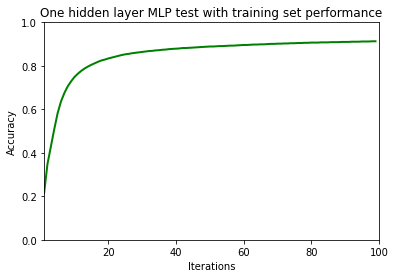

In [ ]:
import matplotlib.pyplot as plt
import xlwt
import os

with open('mlp1.txt','r+') as fd:
  e = list(range(1,100))
  p = []
  #read all accuracy from the performance report
  for text in fd.readlines():
    y=text.split(':')[3].strip("\n").strip('%').strip()
    p.append(y.split("\n"))

  p = list(np.concatenate(p).flat)
  p = [round(float(i)/100,3) for i in p]
  print(p)
  print(e)

fd.close()

plt.plot(e, p, color='green',  linewidth = 2)
  
# setting x and y axis range
plt.ylim(0,1)
plt.xlim(1,100)
  
# naming the x axis
plt.xlabel('Iterations')
# naming the y axis
plt.ylabel('Accuracy')
  
# giving a title to my graph
plt.title('One hidden layer MLP test with training set performance')
  
# function to show the plot
plt.show()


In [ ]:

class MLP_2():

  # initialization
  def __init__(self, sizes, epochs=100, l_rate=0.001):
      self.sizes = sizes
      self.epochs = epochs
      self.l_rate = l_rate
      self.params = self.initialization()

  def softmax(self, x, derivative=False):
          exps = np.exp(x - x.max())
          if derivative:
              return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
          return exps / np.sum(exps, axis=0)

  def sigmoid(self, x, derivative=False):
          if derivative:
              return (np.exp(-x))/((np.exp(-x)+1)**2)
          return 1/(1 + np.exp(-x))

  def ReLU(self, x, derivative = False):
        if derivative:
          y = x
          y[y <= 0] = 0
          y[y > 0] = 1
          return y
        x[x <= 0] = 0
        return x


  # with one hidden layer
  def initialization(self):
          # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        output_layer=self.sizes[3]

        params = {
            'W0':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W1':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W2':np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }

        return params


  def forward(self, x_train):
        params = self.params
        params['A0'] = x_train
        # from input layer to hidden layer1
        params['A1']=np.dot(params['W0'], params['A0'])
        params['S1'] =self.ReLU(params['A1'])

        # hidden layer1 to hidden layer2
        params['A2'] = np.dot(params["W1"], params['S1'])
        params['S2'] = self.ReLU(params['A2'])

        # hidden layer 2 to output layer
        params['A3'] = np.dot(params["W2"], params['S2'])
        params['S3'] = self.softmax(params['A3'])

        return params['S3']

  def backward(self, y_train, output):
        params = self.params
        changes_to_w = {}

        # Calculate W3 update
        error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['A3'], derivative=True)
        changes_to_w['W2'] = np.outer(error, params['S2'])

        # Calculate W1 update
        error = np.dot(params['W2'].T, error) * self.ReLU(params['A2'],derivative=True)
        changes_to_w['W1'] = np.outer(error, params['S1'])

        # Calculate W0 update
        error = np.dot(params['W1'].T, error) * self.ReLU(params['A1'],derivative=True)
        changes_to_w['W0'] = np.outer(error, params['A0'])

        return changes_to_w

  def update_network_parameters(self, changes_to_w):        
          for key, value in changes_to_w.items():
              self.params[key] -= self.l_rate * value

  def train(self, x_train, y_train, x_val, y_val):
          start_time = time.time()
          for iteration in range(self.epochs):
              for x,y in zip(x_train, y_train):
                  output = self.forward(x)
                  changes_to_w = self.backward(y, output)
                  self.update_network_parameters(changes_to_w)
              
              accuracy = self.evaluate_acc(x_val, y_val)
              print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                  iteration+1, time.time() - start_time, accuracy * 100
              ))
  def evaluate_acc(self, x_val, y_val):
          predictions = []

          for x, y in zip(x_val, y_val):
              output = self.forward(x)
              pred = np.argmax(output)
              predictions.append(pred == np.argmax(y))
          
          return np.mean(predictions)

In [ ]:
mlp2 = MLP_2(sizes=[784,128,128,10])
mlp2.train(x_train,y_train,x_train,y_train)

Epoch: 1, Time Spent: 60.90s, Accuracy: 80.86%
Epoch: 2, Time Spent: 121.82s, Accuracy: 86.47%
Epoch: 3, Time Spent: 182.58s, Accuracy: 88.49%
Epoch: 4, Time Spent: 243.56s, Accuracy: 89.65%
Epoch: 5, Time Spent: 304.15s, Accuracy: 90.44%
Epoch: 6, Time Spent: 365.29s, Accuracy: 91.08%
Epoch: 7, Time Spent: 426.79s, Accuracy: 91.58%
Epoch: 8, Time Spent: 488.60s, Accuracy: 91.98%
Epoch: 9, Time Spent: 549.66s, Accuracy: 92.28%
Epoch: 10, Time Spent: 610.75s, Accuracy: 92.61%
Epoch: 11, Time Spent: 671.41s, Accuracy: 92.87%
Epoch: 12, Time Spent: 732.21s, Accuracy: 93.06%
Epoch: 13, Time Spent: 792.84s, Accuracy: 93.29%
Epoch: 14, Time Spent: 853.23s, Accuracy: 93.48%
Epoch: 15, Time Spent: 913.83s, Accuracy: 93.62%
Epoch: 16, Time Spent: 973.98s, Accuracy: 93.79%
Epoch: 17, Time Spent: 1034.12s, Accuracy: 93.95%
Epoch: 18, Time Spent: 1094.57s, Accuracy: 94.09%
Epoch: 19, Time Spent: 1154.53s, Accuracy: 94.25%
Epoch: 20, Time Spent: 1214.56s, Accuracy: 94.39%
Epoch: 21, Time Spent: 127

In [ ]:

class MLP_2_sigmoid():

  # initialization
  def __init__(self, sizes, epochs=100, l_rate=0.001):
      self.sizes = sizes
      self.epochs = epochs
      self.l_rate = l_rate
      self.params = self.initialization()

  def softmax(self, x, derivative=False):
          exps = np.exp(x - x.max())
          if derivative:
              return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
          return exps / np.sum(exps, axis=0)

  def sigmoid(self, x, derivative=False):
          if derivative:
              return (np.exp(-x))/((np.exp(-x)+1)**2)
          return 1/(1 + np.exp(-x))

  def ReLU(self, x, derivative = False):
        if derivative:
          y = x
          y[y <= 0] = 0
          y[y > 0] = 1
          return y
        x[x <= 0] = 0
        return x


  # with one hidden layer
  def initialization(self):
          # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        output_layer=self.sizes[3]

        params = {
            'W0':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W1':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W2':np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }

        return params


  def forward(self, x_train):
        params = self.params
        params['A0'] = x_train
        # from input layer to hidden layer1
        params['A1']=np.dot(params['W0'], params['A0'])
        params['S1'] =self.sigmoid(params['A1'])

        # hidden layer1 to hidden layer2
        params['A2'] = np.dot(params["W1"], params['S1'])
        params['S2'] = self.sigmoid(params['A2'])

        # hidden layer 2 to output layer
        params['A3'] = np.dot(params["W2"], params['S2'])
        params['S3'] = self.softmax(params['A3'])

        return params['S3']

  def backward(self, y_train, output):
        params = self.params
        changes_to_w = {}

        # Calculate W3 update
        error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['A3'], derivative=True)
        changes_to_w['W2'] = np.outer(error, params['S2'])

        # Calculate W1 update
        error = np.dot(params['W2'].T, error) * self.sigmoid(params['A2'],derivative=True)
        changes_to_w['W1'] = np.outer(error, params['S1'])

        # Calculate W0 update
        error = np.dot(params['W1'].T, error) * self.sigmoid(params['A1'],derivative=True)
        changes_to_w['W0'] = np.outer(error, params['A0'])

        return changes_to_w

  def update_network_parameters(self, changes_to_w):        
          for key, value in changes_to_w.items():
              self.params[key] -= self.l_rate * value

  def train(self, x_train, y_train, x_val, y_val):
          start_time = time.time()
          for iteration in range(self.epochs):
              for x,y in zip(x_train, y_train):
                  output = self.forward(x)
                  changes_to_w = self.backward(y, output)
                  self.update_network_parameters(changes_to_w)
              
              accuracy = self.evaluate_acc(x_val, y_val)
              print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                  iteration+1, time.time() - start_time, accuracy * 100
              ))
  def evaluate_acc(self, x_val, y_val):
          predictions = []

          for x, y in zip(x_val, y_val):
              output = self.forward(x)
              pred = np.argmax(output)
              predictions.append(pred == np.argmax(y))
          
          return np.mean(predictions)

In [ ]:
mlp2_sig = MLP_2_sigmoid(sizes=[784,128,128,10])
mlp2_sig.train(x_train,y_train,x_train,y_train)

Epoch: 1, Time Spent: 70.56s, Accuracy: 29.03%
Epoch: 2, Time Spent: 141.01s, Accuracy: 32.98%
Epoch: 3, Time Spent: 207.09s, Accuracy: 36.14%
Epoch: 4, Time Spent: 274.02s, Accuracy: 40.57%
Epoch: 5, Time Spent: 341.56s, Accuracy: 46.52%
Epoch: 6, Time Spent: 408.51s, Accuracy: 52.03%
Epoch: 7, Time Spent: 477.72s, Accuracy: 55.99%
Epoch: 8, Time Spent: 544.31s, Accuracy: 58.37%
Epoch: 9, Time Spent: 610.89s, Accuracy: 60.05%
Epoch: 10, Time Spent: 677.84s, Accuracy: 61.46%
Epoch: 11, Time Spent: 746.37s, Accuracy: 62.61%
Epoch: 12, Time Spent: 812.04s, Accuracy: 63.65%
Epoch: 13, Time Spent: 877.56s, Accuracy: 64.60%
Epoch: 14, Time Spent: 943.87s, Accuracy: 65.38%
Epoch: 15, Time Spent: 1011.75s, Accuracy: 66.11%
Epoch: 16, Time Spent: 1077.80s, Accuracy: 66.80%
Epoch: 17, Time Spent: 1145.52s, Accuracy: 67.44%
Epoch: 18, Time Spent: 1212.60s, Accuracy: 67.93%
Epoch: 19, Time Spent: 1280.17s, Accuracy: 68.40%
Epoch: 20, Time Spent: 1351.72s, Accuracy: 68.79%
Epoch: 21, Time Spent: 1

In [ ]:
class MLP_2_tanh():

# initialization
  def __init__(self, sizes, epochs=100, l_rate=0.001):
      self.sizes = sizes
      self.epochs = epochs
      self.l_rate = l_rate
      self.params = self.initialization()

  def softmax(self, x, derivative=False):
          exps = np.exp(x - x.max())
          if derivative:
              return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
          return exps / np.sum(exps, axis=0)

  def sigmoid(self, x, derivative=False):
          if derivative:
              return (np.exp(-x))/((np.exp(-x)+1)**2)
          return 1/(1 + np.exp(-x))

  def ReLU(self, x, derivative = False):
        if derivative:
          y = x
          y[y <= 0] = 0
          y[y > 0] = 1
          return y
        x[x <= 0] = 0
        return x
  def tanh(self, x, derivative = False):
        t=(np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
        dt=1-t**2
        if derivative:
          return dt
        return t


  # with one hidden layer
  def initialization(self):
          # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        output_layer=self.sizes[3]

        params = {
            'W0':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W1':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W2':np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }

        return params


  def forward(self, x_train):
        params = self.params
        params['A0'] = x_train
        # from input layer to hidden layer1
        params['A1']=np.dot(params['W0'], params['A0'])
        params['S1'] =self.tanh(params['A1'])

        # hidden layer1 to hidden layer2
        params['A2'] = np.dot(params["W1"], params['S1'])
        params['S2'] = self.tanh(params['A2'])

        # hidden layer 2 to output layer
        params['A3'] = np.dot(params["W2"], params['S2'])
        params['S3'] = self.softmax(params['A3'])

        return params['S3']

  def backward(self, y_train, output):
        params = self.params
        changes_to_w = {}

        # Calculate W3 update
        error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['A3'], derivative=True)
        changes_to_w['W2'] = np.outer(error, params['S2'])

        # Calculate W1 update
        error = np.dot(params['W2'].T, error) * self.tanh(params['A2'],derivative=True)
        changes_to_w['W1'] = np.outer(error, params['S1'])

        # Calculate W0 update
        error = np.dot(params['W1'].T, error) * self.tanh(params['A1'],derivative=True)
        changes_to_w['W0'] = np.outer(error, params['A0'])

        return changes_to_w

  def update_network_parameters(self, changes_to_w):        
          for key, value in changes_to_w.items():
              self.params[key] -= self.l_rate * value

  def train(self, x_train, y_train, x_val, y_val):
          start_time = time.time()
          for iteration in range(self.epochs):
              for x,y in zip(x_train, y_train):
                  output = self.forward(x)
                  changes_to_w = self.backward(y, output)
                  self.update_network_parameters(changes_to_w)
              
              accuracy = self.evaluate_acc(x_val, y_val)
              print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                  iteration+1, time.time() - start_time, accuracy * 100
              ))
  def evaluate_acc(self, x_val, y_val):
          predictions = []

          for x, y in zip(x_val, y_val):
              output = self.forward(x)
              pred = np.argmax(output)
              predictions.append(pred == np.argmax(y))
          return np.mean(predictions)

In [ ]:
mlp2_tanh = MLP_2_tanh(sizes=[784,128,128,10])
mlp2_tanh.train(x_train,y_train,x_train,y_train)

Epoch: 1, Time Spent: 67.98s, Accuracy: 82.53%
Epoch: 2, Time Spent: 135.83s, Accuracy: 86.48%
Epoch: 3, Time Spent: 203.55s, Accuracy: 88.11%
Epoch: 4, Time Spent: 271.24s, Accuracy: 89.17%
Epoch: 5, Time Spent: 338.92s, Accuracy: 89.91%
Epoch: 6, Time Spent: 406.45s, Accuracy: 90.45%
Epoch: 7, Time Spent: 473.87s, Accuracy: 90.92%
Epoch: 8, Time Spent: 541.26s, Accuracy: 91.28%
Epoch: 9, Time Spent: 608.77s, Accuracy: 91.61%
Epoch: 10, Time Spent: 676.25s, Accuracy: 91.90%
Epoch: 11, Time Spent: 743.90s, Accuracy: 92.09%
Epoch: 12, Time Spent: 811.43s, Accuracy: 92.31%
Epoch: 13, Time Spent: 879.17s, Accuracy: 92.53%
Epoch: 14, Time Spent: 946.89s, Accuracy: 92.74%
Epoch: 15, Time Spent: 1014.73s, Accuracy: 92.92%
Epoch: 16, Time Spent: 1082.15s, Accuracy: 93.08%
Epoch: 17, Time Spent: 1149.54s, Accuracy: 93.23%
Epoch: 18, Time Spent: 1217.15s, Accuracy: 93.37%
Epoch: 19, Time Spent: 1284.84s, Accuracy: 93.51%
Epoch: 20, Time Spent: 1352.10s, Accuracy: 93.61%
Epoch: 21, Time Spent: 1